In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


# ============================================================
# Utility: Interquartile Mean (IQM)
# ============================================================
def iqm(values):
    values = np.sort(np.asarray(values))
    n = len(values)
    lo = int(0.25 * n)
    hi = int(0.75 * n)
    if hi <= lo:
        return float(np.mean(values))
    return float(np.mean(values[lo:hi]))


# ============================================================
# Stage-2: Load **OFFLINE** evaluation returns
# ============================================================
def collect_offline_G_values_single_config(
    log_dir,
    start_step=900_000,
    file_suffixes=(".json", ".jso")
):
    """
    Returns:
        G_vals: list of offline FINAL SCORES for each run
        summary: DataFrame with Mean, Std, Median, IQM
    """

    folder = Path(r"\\?\\" + str(Path(log_dir).resolve()))
    files = []
    for suf in file_suffixes:
        files += list(folder.glob(f"*{suf}"))

    print(f"\n🔍 Looking in: {folder}")
    print(f"Found {len(files)} logs.")

    G_vals = []

    for p in files:
        with p.open("r") as f:
            d = json.load(f)

        # Get evaluation events AFTER 900k
        evals = [
            e for e in d["events"]
            if e["event"] == "evaluation" and e.get("total_steps", 0) >= start_step
        ]

        if len(evals) == 0:
            continue

        # Final evaluation score
        last_eval = evals[-1]
        G_vals.append(float(last_eval["average_return"]))

    G_vals = np.array(G_vals)

    summary = pd.DataFrame([{
        "Mean_G":   np.mean(G_vals),
        "Std_G":    np.std(G_vals),
        "Median_G": np.median(G_vals),
        "IQM_G":    iqm(G_vals),
        "Num_Runs": len(G_vals)
    }])

    print("\n📊 Stage-2 OFFLINE Summary:")
    print(summary.to_string(index=False, float_format=lambda x: f"{x:,.2f}"))

    return G_vals, summary


# ============================================================
# Bootstrap Mean Difference
# ============================================================
def bootstrap_mean_difference(G_A, G_B, B=10000, alpha=0.05,
                              label_A="A", label_B="B"):

    G_A, G_B = np.asarray(G_A), np.asarray(G_B)
    obs = np.mean(G_A) - np.mean(G_B)
    boot = []

    for _ in range(B):
        A_s = np.random.choice(G_A, len(G_A), replace=True)
        B_s = np.random.choice(G_B, len(G_B), replace=True)
        boot.append(np.mean(A_s) - np.mean(B_s))

    lo, up = np.percentile(boot, [alpha/2 * 100, (1 - alpha/2) * 100])

    print("\n================ MEAN DIFFERENCE BOOTSTRAP ================")
    print(f"{label_A} - {label_B} = {obs:.2f}")
    print(f"{int((1-alpha)*100)}% CI: [{lo:.2f}, {up:.2f}]")

    if lo > 0:
        print(f"→ {label_A} significantly BETTER")
    elif up < 0:
        print(f"→ {label_A} significantly WORSE")
    else:
        print("→ No significant difference")


# ============================================================
# Bootstrap IQM Difference
# ============================================================
def bootstrap_iqm_difference(G_A, G_B, B=10000, alpha=0.05,
                              label_A="A", label_B="B"):

    G_A, G_B = np.asarray(G_A), np.asarray(G_B)
    obs = iqm(G_A) - iqm(G_B)
    boot = []

    for _ in range(B):
        A_s = np.random.choice(G_A, len(G_A), replace=True)
        B_s = np.random.choice(G_B, len(G_B), replace=True)
        boot.append(iqm(A_s) - iqm(B_s))

    lo, up = np.percentile(boot, [alpha/2 * 100, (1 - alpha/2) * 100])

    print("\n================ IQM DIFFERENCE BOOTSTRAP ================")
    print(f"IQM[{label_A}] - IQM[{label_B}] = {obs:.2f}")
    print(f"{int((1-alpha)*100)}% CI: [{lo:.2f}, {up:.2f}]")


# ============================================================
# CDF with tolerance band
# ============================================================
def cdf_with_band(values, B=2000, num_points=200, alpha=0.05):

    values = np.asarray(values)
    xs = np.linspace(values.min(), values.max(), num_points)

    base = np.array([np.mean(values <= x) for x in xs])
    boots = []

    for _ in range(B):
        s = np.random.choice(values, len(values), replace=True)
        boots.append([np.mean(s <= x) for x in xs])

    boots = np.array(boots)
    lo = np.percentile(boots, alpha/2 * 100, axis=0)
    up = np.percentile(boots, (1 - alpha/2) * 100, axis=0)

    return xs, base, lo, up


def plot_cdf_comparison(G_A, G_B, label_A="A", label_B="B"):
    xsA, cdfA, loA, upA = cdf_with_band(G_A)
    xsB, cdfB, loB, upB = cdf_with_band(G_B)

    plt.figure(figsize=(8,6))

    # PPO — blue
    plt.plot(xsA, cdfA, linewidth=2, color="#1f77b4", label=label_A)
    plt.fill_between(xsA, loA, upA, color="#1f77b4", alpha=0.2)

    # TRPO — orange
    plt.plot(xsB, cdfB, linewidth=2, color="#ff7f0e", label=label_B)
    plt.fill_between(xsB, loB, upB, color="#ff7f0e", alpha=0.2)

    plt.title("CDF of Offline Evaluation Scores")
    plt.xlabel("Final Offline Score")
    plt.ylabel("P(G ≤ x)")
    plt.grid(alpha=0.3, linestyle="--")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ============================================================
# Load full training curves (online)
# ============================================================
def load_full_learning_curves(log_dir, suffixes=(".json",".jso")):

    folder = Path(r"\\?\\" + str(Path(log_dir).resolve()))
    files = []
    for suf in suffixes:
        files += list(folder.glob(f"*{suf}"))

    runs = []
    for p in files:
        with p.open("r") as f:
            d = json.load(f)

        ev = [e for e in d["events"] if e["event"] == "train_episode"]
        if len(ev) == 0:
            continue

        steps = np.array([e["total_steps"] for e in ev])
        avg   = np.array([e["average_return"] for e in ev])
        runs.append((steps, avg))

    return runs



# ============================================================
# Align curves from 900k steps onward
# ============================================================
def align_from_start(runs, start_step=900_000):

    aligned = []
    for steps, avg in runs:
        mask = steps >= start_step
        if not np.any(mask):
            continue
        aligned.append((steps[mask], avg[mask]))

    min_end = min(st[-1] for st, _ in aligned)
    x_common = np.linspace(start_step, min_end, 300)

    arr = []
    for st, av in aligned:
        arr.append(np.interp(x_common, st, av))

    return x_common, np.vstack(arr)



# ============================================================
# Plot Learning Curve ≥900k
# ============================================================
def plot_learning_curve_from_900k(ppo_runs, trpo_runs,
                                  start_step=900_000,
                                  label_A="PPO*", label_B="TRPO*"):

    xA, arrA = align_from_start(ppo_runs, start_step)
    xB, arrB = align_from_start(trpo_runs, start_step)

    meanA = arrA.mean(axis=0)
    meanB = arrB.mean(axis=0)

    loA = np.percentile(arrA, 2.5, axis=0)
    upA = np.percentile(arrA, 97.5, axis=0)

    loB = np.percentile(arrB, 2.5, axis=0)
    upB = np.percentile(arrB, 97.5, axis=0)

    plt.figure(figsize=(10,6))
    plt.title("Learning Curve (Online Data ≥900k)", fontsize=15)

    plt.plot(xA, meanA, color="#1f77b4", linewidth=2, label=label_A)
    plt.fill_between(xA, loA, upA, color="#1f77b4", alpha=0.2)

    plt.plot(xB, meanB, color="#ff7f0e", linewidth=2, label=label_B)
    plt.fill_between(xB, loB, upB, color="#ff7f0e", alpha=0.2)

    plt.xlabel("Steps")
    plt.ylabel("Average Return")
    plt.grid(alpha=0.3, linestyle="--")
    plt.legend()
    plt.tight_layout()
    plt.show()



# ============================================================
# Multi-environment Normalized CDF
# ============================================================
def empirical_cdf(values, num_points=200):
    values = np.asarray(values)
    xs = np.linspace(0, 1, num_points)
    cdf = np.array([np.mean(values <= x) for x in xs])
    return xs, cdf


def normalize_env(G_ppo_env, G_trpo_env):
    all_scores = np.concatenate([G_ppo_env, G_trpo_env])
    min_s, max_s = np.min(all_scores), np.max(all_scores)

    if max_s - min_s < 1e-9:
        return np.zeros_like(G_ppo_env), np.zeros_like(G_trpo_env)

    return (
        (G_ppo_env - min_s) / (max_s - min_s),
        (G_trpo_env - min_s) / (max_s - min_s),
    )


def normalized_cdf_all_envs(G_ppo_dict, G_trpo_dict,
                             label_A="PPO*", label_B="TRPO*"):

    ppo_all = []
    trpo_all = []

    for env in G_ppo_dict.keys():

        G_ppo_env = np.asarray(G_ppo_dict[env])
        G_trpo_env = np.asarray(G_trpo_dict[env])

        nA, nB = normalize_env(G_ppo_env, G_trpo_env)
        ppo_all.append(nA)
        trpo_all.append(nB)

        print(f"✓ Normalized env: {env} ({len(nA)} PPO runs, {len(nB)} TRPO runs)")

    ppo_all = np.concatenate(ppo_all)
    trpo_all = np.concatenate(trpo_all)

    xs, cdfA = empirical_cdf(ppo_all)
    _,  cdfB = empirical_cdf(trpo_all)

    plt.figure(figsize=(9,6))
    plt.plot(xs, cdfA, linewidth=2.2, color="#1f77b4", label=label_A)
    plt.plot(xs, cdfB, linewidth=2.2, color="#ff7f0e", label=label_B)

    plt.title("Multi-Environment Normalized Performance Profile")
    plt.xlabel("Normalized Score (0–1)")
    plt.ylabel("CDF — Fraction of Runs ≤ Score")
    plt.grid(alpha=0.3, linestyle="--")
    plt.legend()
    plt.tight_layout()
    plt.show()




🔍 Looking in: \\?\\C:\Users\Phong\OneDrive\Documents\VSCODEFILE\CMPUT665-PROJECT\ppo_ant
Found 128 logs.

📊 Stage-2 OFFLINE Summary:
  Mean_G  Std_G  Median_G    IQM_G  Num_Runs
1,688.60 315.57  1,675.15 1,674.14       128

🔍 Looking in: \\?\\C:\Users\Phong\OneDrive\Documents\VSCODEFILE\CMPUT665-PROJECT\trpo_ant
Found 96 logs.

📊 Stage-2 OFFLINE Summary:
 Mean_G  Std_G  Median_G  IQM_G  Num_Runs
 931.29 319.58    870.45 897.86        96

🔍 Looking in: \\?\\C:\Users\Phong\OneDrive\Documents\VSCODEFILE\CMPUT665-PROJECT\ppo_chet
Found 128 logs.

📊 Stage-2 OFFLINE Summary:
  Mean_G    Std_G  Median_G    IQM_G  Num_Runs
3,072.89 1,092.35  3,188.95 3,217.09       128

🔍 Looking in: \\?\\C:\Users\Phong\OneDrive\Documents\VSCODEFILE\CMPUT665-PROJECT\trpo_chet
Found 96 logs.

📊 Stage-2 OFFLINE Summary:
  Mean_G  Std_G  Median_G    IQM_G  Num_Runs
2,463.46 903.72  2,531.18 2,489.96        96

================ MEAN DIFFERENCE BOOTSTRAP ================
PPO* (Ant) - TRPO* (Ant) = 757.31
95% CI: [

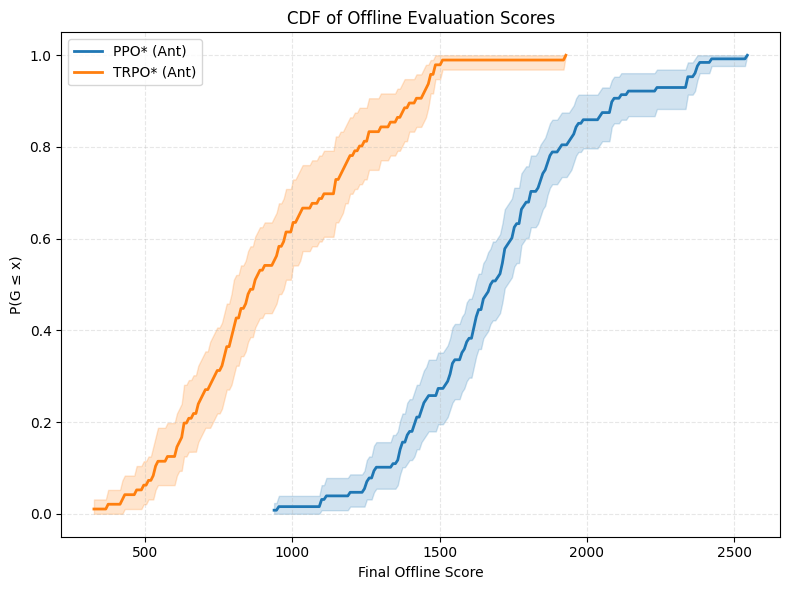

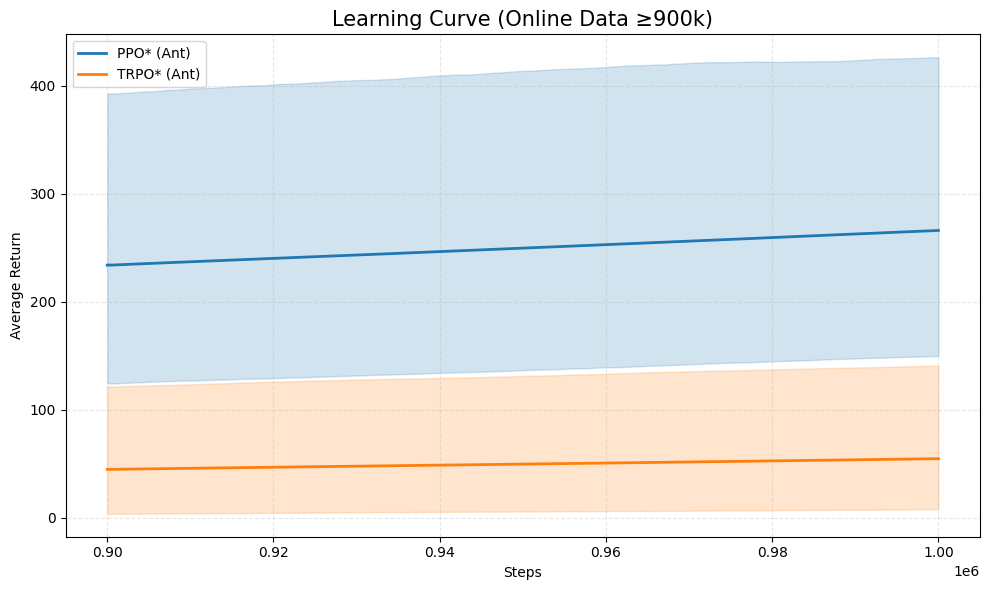

✓ Normalized env: Ant (128 PPO runs, 96 TRPO runs)
✓ Normalized env: Cheetah (128 PPO runs, 96 TRPO runs)


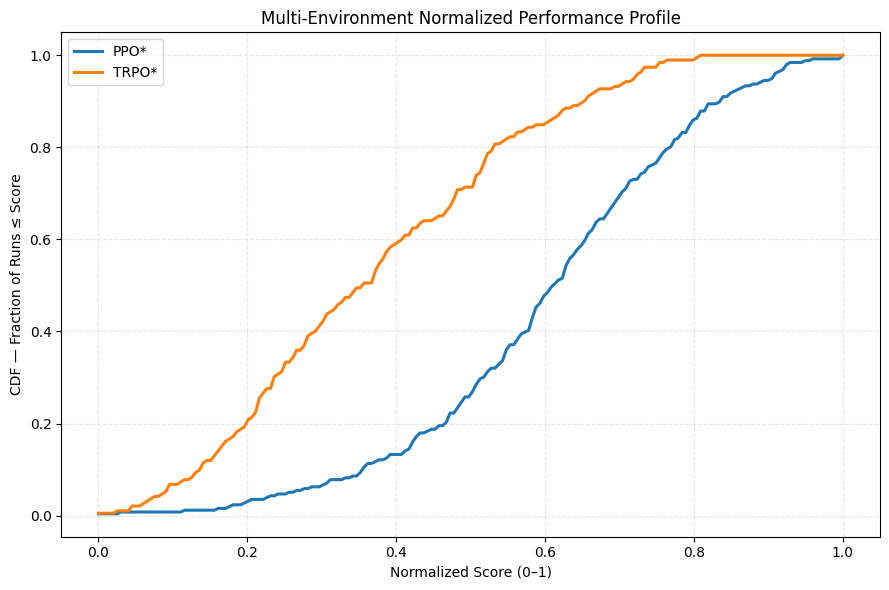

In [2]:
# ============================================================
# Load OFFLINE scores for ANT
# ============================================================
G_ppo_ant, _ = collect_offline_G_values_single_config(
    r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/ppo_ant"
)
G_trpo_ant, _ = collect_offline_G_values_single_config(
    r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/trpo_ant"
)

# ============================================================
# Load OFFLINE scores for HalfCheetah
# ============================================================
G_ppo_chet, _ = collect_offline_G_values_single_config(
    r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/ppo_chet"
)
G_trpo_chet, _ = collect_offline_G_values_single_config(
    r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/trpo_chet"
)

# ============================================================
# Statistical Comparison
# ============================================================
bootstrap_mean_difference(G_ppo_ant, G_trpo_ant,
                          label_A="PPO* (Ant)", label_B="TRPO* (Ant)")

bootstrap_iqm_difference(G_ppo_ant, G_trpo_ant,
                         label_A="PPO* (Ant)", label_B="TRPO* (Ant)")

plot_cdf_comparison(G_ppo_ant, G_trpo_ant,
                    label_A="PPO* (Ant)", label_B="TRPO* (Ant)")

# ============================================================
# Learning Curves ≥900k
# ============================================================
ppo_runs_ant = load_full_learning_curves(
    r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/ppo_ant"
)
trpo_runs_ant = load_full_learning_curves(
    r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/trpo_ant"
)

plot_learning_curve_from_900k(ppo_runs_ant, trpo_runs_ant,
                              label_A="PPO* (Ant)", label_B="TRPO* (Ant)")

# ============================================================
# Multi-Environment Normalized CDF
# ============================================================
normalized_cdf_all_envs(
    G_ppo_dict={"Ant": G_ppo_ant, "Cheetah": G_ppo_chet},
    G_trpo_dict={"Ant": G_trpo_ant, "Cheetah": G_trpo_chet},
    label_A="PPO*",
    label_B="TRPO*"
)
